# Plant Disease Detection via Leaf Anomaly Analysis Using CNN (VGG16 Architecture)

In [1]:
!pip install -q protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
bigframes 2.26.0 requires rich<1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import os
import shutil
import random
from pathlib import Path

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

2026-01-10 16:45:27.748995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768063527.956041      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768063528.013218      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768063528.483855      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768063528.483903      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768063528.483907      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

# ---------------- CONFIG ----------------
SOURCE_DIR = Path("/kaggle/input/plants-dataset/Plants-Dataset")
DEST_DIR   = Path("/kaggle/working/plants_split")

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.2
TEST_RATIO  = 0.1

SEED = 42
random.seed(SEED)

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6

# ---------------- CREATE FOLDERS ----------------
for split in ["train", "val", "test"]:
    (DEST_DIR / split).mkdir(parents=True, exist_ok=True)

# ---------------- SPLIT DATA ----------------
for class_dir in SOURCE_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    images = list(class_dir.glob("*"))
    images = [img for img in images if img.suffix.lower() in [".jpg", ".png", ".jpeg"]]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val   = int(n_total * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:]
    }

    for split_name, split_imgs in splits.items():
        split_class_dir = DEST_DIR / split_name / class_dir.name
        split_class_dir.mkdir(parents=True, exist_ok=True)

        for img_path in split_imgs:
            shutil.copy2(img_path, split_class_dir / img_path.name)

    print(f"{class_dir.name}: "
          f"Train={len(splits['train'])}, "
          f"Val={len(splits['val'])}, "
          f"Test={len(splits['test'])}")


Strawberry___Leaf_scorch: Train=776, Val=221, Test=112
Peach___healthy: Train=251, Val=72, Test=37
Apple___Apple_scab: Train=441, Val=126, Test=63
Apple___Black_rot: Train=434, Val=124, Test=63
Peach___Bacterial_spot: Train=1607, Val=459, Test=231
Apple___Cedar_apple_rust: Train=192, Val=55, Test=28
Strawberry___healthy: Train=319, Val=91, Test=46
Apple___healthy: Train=1151, Val=329, Test=165


In [4]:
TRAIN_DIR = "/kaggle/working/plants_split/train"
VAL_DIR   = "/kaggle/working/plants_split/val"
TEST_DIR  = "/kaggle/working/plants_split/test"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [6]:
train_set = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_set = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_set = test_datagen.flow_from_directory(
   TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 5171 images belonging to 8 classes.
Found 1477 images belonging to 8 classes.
Found 745 images belonging to 8 classes.


In [7]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


I0000 00:00:1768063566.548048      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
for layer in base_model.layers:
    layer.trainable = False


In [9]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_set.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [10]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1768063571.855329     147 service.cc:152] XLA service 0x7c240800d2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768063571.855367     147 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768063572.368129     147 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/162 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.1250 - loss: 14.3972 

I0000 00:00:1768063581.001204     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 75s 391ms/step - accuracy: 0.5807 - loss: 4.4272 - val_accuracy: 0.9093 - val_loss: 0.2876
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 343ms/step - accuracy: 0.8204 - loss: 0.6529 - val_accuracy: 0.9418 - val_loss: 0.1751
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 55s 341ms/step - accuracy: 0.8903 - loss: 0.3834 - val_accuracy: 0.9689 - val_loss: 0.0890
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 348ms/step - accuracy: 0.9035 - loss: 0.3211 - val_accuracy: 0.9661 - val_loss: 0.1122
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.9205 - loss: 0.2623 - val_accuracy: 0.9614 - val_loss: 0.1080
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 55s 342ms/step - accuracy: 0.9283 - loss: 0.2222 - val_accuracy: 0.9709 - val_loss: 0.0880
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - accuracy: 0.9334 - loss: 0.2194 - val_accuracy: 0.9729 - val_loss: 0.0813
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - accuracy: 0.9453 - loss: 0.2008 - val

In [12]:
model.save_weights("/kaggle/working/vgg16_transfer.weights.h5")


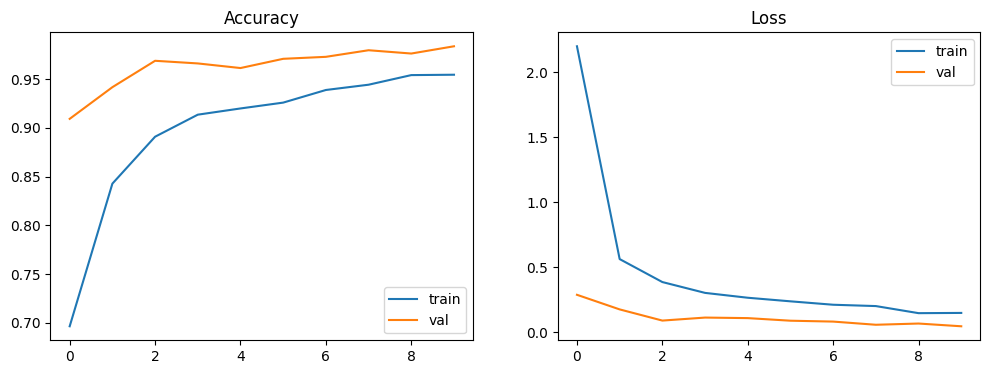

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.show()


In [14]:
test_loss, test_acc = model.evaluate(test_set)
print("Test accuracy:", test_acc)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9583 - loss: 0.1194
Test accuracy: 0.9771811962127686


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step


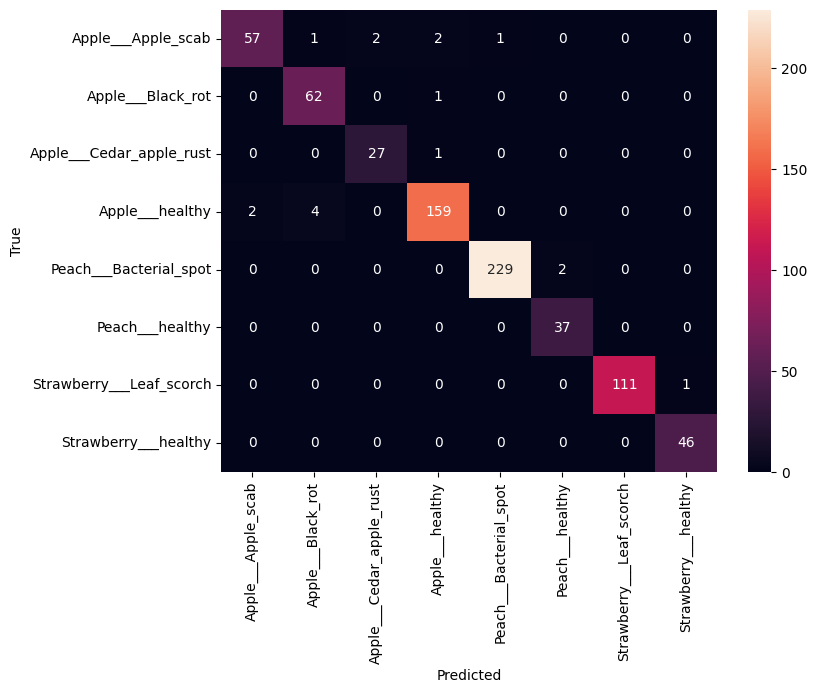

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_set.classes
y_pred = np.argmax(model.predict(test_set), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=test_set.class_indices.keys(),
    yticklabels=test_set.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [16]:
from tensorflow.keras.preprocessing import image

img_path = "/kaggle/input/peachtest/peachtest.jpg"  # your image
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

prediction = model.predict(img)
predicted_class = np.argmax(prediction)

class_names = list(train_set.class_indices.keys())
print("Predicted class:", class_names[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Apple___Apple_scab


In [17]:
from sklearn.metrics import classification_report

# True labels
y_true = test_set.classes

# Model predictions
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names (correct order)
class_names = list(test_set.class_indices.keys())

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print(report)

#Save report to work_space
with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)



24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
                          precision    recall  f1-score   support

      Apple___Apple_scab     0.9661    0.9048    0.9344        63
       Apple___Black_rot     0.9254    0.9841    0.9538        63
Apple___Cedar_apple_rust     0.9310    0.9643    0.9474        28
         Apple___healthy     0.9755    0.9636    0.9695       165
  Peach___Bacterial_spot     0.9957    0.9913    0.9935       231
         Peach___healthy     0.9487    1.0000    0.9737        37
Strawberry___Leaf_scorch     1.0000    0.9911    0.9955       112
    Strawberry___healthy     0.9787    1.0000    0.9892        46

                accuracy                         0.9772       745
               macro avg     0.9651    0.9749    0.9696       745
            weighted avg     0.9776    0.9772    0.9772       745



**Fine-tuning VGG16**

> **Step1 — Unfreeze ONLY the last VGG block**

In [18]:
#VGG16 structure reminder (conceptual):
#Block1 → Block2 → Block3 → Block4 → Block5 → Classifier
#We unfreeze Block5 only.

# Unfreeze last convolutional block
for layer in base_model.layers:
    if "block5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in base_model.layers[-10:]:
    print(layer.name, layer.trainable)


#Verify:
for layer in base_model.layers[-10:]:
    print(layer.name, layer.trainable)


block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


> **Step2 — Recompile**

In [19]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # VERY SMALL LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


> **Step3 — Continue training**

In [20]:
#This is not retraining => It is refinement.

fine_tune_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=2
)

Epoch 1/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 64s 364ms/step - accuracy: 0.9673 - loss: 0.1204 - val_accuracy: 0.9898 - val_loss: 0.0384
Epoch 2/2
162/162 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9758 - loss: 0.0844 - val_accuracy: 0.9946 - val_loss: 0.0243


In [21]:
model.save_weights("/kaggle/working/vgg16_finetuned.weights.h5")

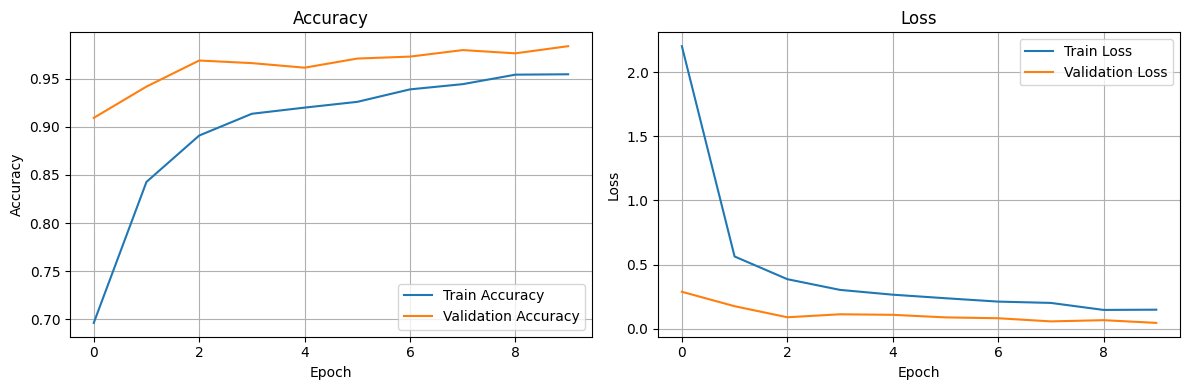

Test accuracy: 0.990604043006897
Test loss: 0.03416102007031441


In [30]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12,4))

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save plots to Kaggle working directory
plt.savefig("/kaggle/working/fine_tuning_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_set, verbose=0)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)
